In [5]:
from minicons import scorer
import numpy as np

def prob_to_surprisal(prob):
    if prob == 0: # ignore
        return 0
    return -np.log(prob)

ilm_model = scorer.IncrementalLMScorer('gpt2', 'cuda') # distilgpt2 is a lightweight version of GPT-2 (faster)

sentences = ["Is this a butterfly?"]

res = ilm_model.token_score(sentences, bos_token=True, eos_token=False, prob=True)
print(res)
pairs = res[0]
sum_ = 0
for i in range(len(pairs)):
    sum_ += prob_to_surprisal(pairs[i][1])
print(sum_ / (len(pairs)-1))
print(ilm_model.sequence_score(sentences, reduction = lambda x:  -x.sum(0).item())) # average surprisal of the sequence (normalized by sequence length)

[[('<|endoftext|>', 0.0), ('Is', 0.0009095994755625725), ('this', 0.1084214597940445), ('a', 0.12814557552337646), ('butterfly', 1.6711132047930732e-05), ('?', 0.20482760667800903)]]
4.772769170638881
[18.944387435913086]


In [2]:
import numpy as np
from surprisal import AutoHuggingFaceModel

sentences = ["Is this a butterfly?"]

m = AutoHuggingFaceModel.from_pretrained('gpt2')
m.to('cuda')

# surprisal = - log(probability)
for result in m.surprise(sentences):
    for token, surprisal in zip(result.tokens, result._surprisals):
        print(token, surprisal)
    average = sum(result._surprisals) / len(result._surprisals)
    print(average) # remove the surprisal coming from punctuation

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Is 7.000580787658691
Ġthis 2.2217044830322266
Ġa 2.0545661449432373
Ġbutterfly 10.999431610107422
? 1.5855426788330078
4.772365140914917


c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [6]:
mlm_model = scorer.MaskedLMScorer('bert-base-uncased', 'cuda') 

sentences = ["Is this a butterfly?"]

res = mlm_model.token_score(sentences, surprisal=True)
print(res)

[[('is', 0.5247116088867188), ('this', 2.7940359115600586), ('a', 0.061405181884765625), ('butterfly', 11.375964164733887), ('?', 0.0005893707275390625)]]


In [2]:
# read complexities.json
import json

with open('complexities.json') as f:
    complexities = json.load(f)


108079


In [4]:
# read features_filtered.csv

import pandas as pd
import numpy as np
from tqdm import tqdm


df = pd.read_csv('features.csv')
# calculate corr between surprisal and features

print(df['# of SAM 2 segmentations'].corr(df['# of SAM segmentations'], method='spearman'))
print(df['# of SAM 2 segmentations'].corr(df['# of FC-CLIP classes'], method='spearman'))
print(df['# of SAM 2 segmentations'].corr(df['# of objects'], method='spearman'))

print(df['# of SAM segmentations'].corr(df['# of FC-CLIP classes'], method='spearman'))
print(df['# of SAM segmentations'].corr(df['# of objects'], method='spearman'))

print(df['# of FC-CLIP classes'].corr(df['# of objects'], method='spearman'))

0.7486563870149014
0.5450734696048275
0.22640723380184874
0.5923929879031707
0.2821527262278329
0.25304749527575965


In [5]:
# add complexities to features.csv

for id in tqdm(df['image_id']):
    df.loc[df['image_id'] == id, 'complexity'] = complexities[str(id)]

100%|██████████| 108077/108077 [00:26<00:00, 4105.68it/s]


In [7]:
#save to features_complexities.csv
df.to_csv('features_complexities.csv', index=False)

In [2]:
import pandas as pd

C:\Users\karab\AppData\Local\Temp\ipykernel_1684\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


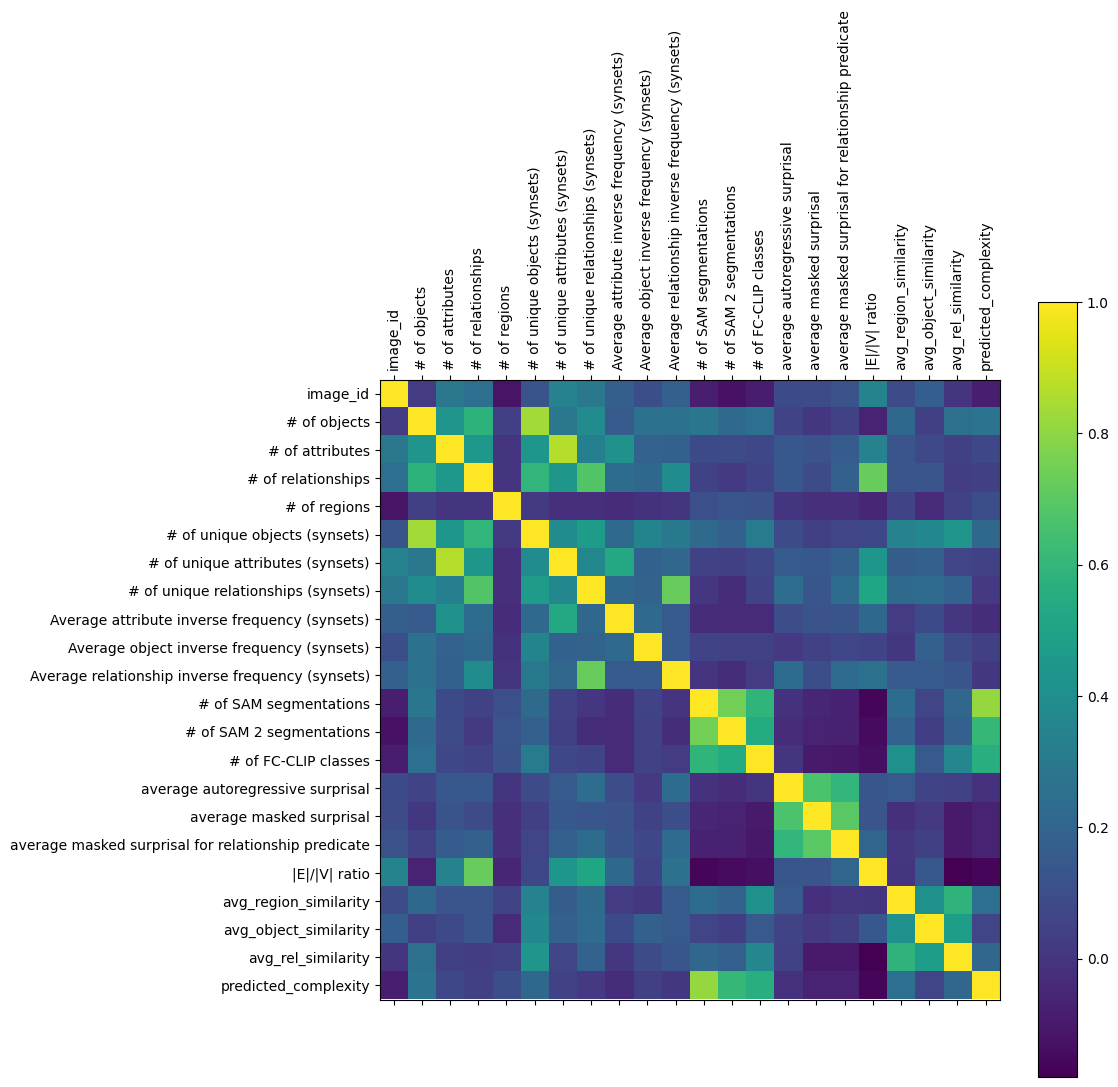

In [21]:
df = pd.read_csv('features.csv')

# get correlation of all features on a heatmap
# create a heatmap of correlations between all features
df["avg_object_similarity"] *= -1
df["avg_region_similarity"] *= -1
df["avg_rel_similarity"] *= -1
# put feature labels
corr = df.corr(method='spearman')
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()


In [214]:
# take a random subsample of 1000 images
import random

sample = random.sample(list(df['image_id']), 10000)
df_sample = df[df['image_id'].isin(sample)]

print_cors(df_sample)

0.6014111429652294
0.8036063250315627
0.5542074636890443
0.046092626659929734
0.246756457685643
0.2010071202132396


In [50]:
# write samples to a txt

with open('sample.txt', 'w') as f:
    for item in sample:
        f.write("%s\n" % item)

In [23]:
# print correlations between features and complexity

def print_cors(df):
    print(df['predicted_complexity'].corr(df['# of SAM 2 segmentations'], method='spearman'))
    print(df['predicted_complexity'].corr(df['# of SAM segmentations'], method='spearman'))
    print(df['predicted_complexity'].corr(df['# of FC-CLIP classes'], method='spearman'))
    print(df['predicted_complexity'].corr(df['avg_object_similarity'], method='spearman'))
    print(df['predicted_complexity'].corr(df['avg_region_similarity'], method='spearman'))
    print(df['predicted_complexity'].corr(df['avg_rel_similarity'], method='spearman'))


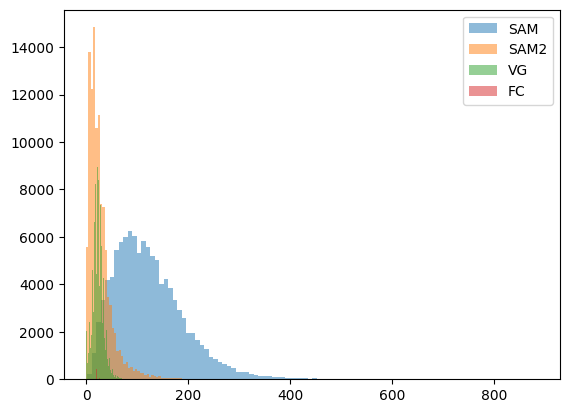

In [8]:
# read SAM
sam = df["# of SAM segmentations"]
sam2 = df["# of SAM 2 segmentations"]
vg = df["# of objects"]
fc = df["# of FC-CLIP classes"]

# histogram
import matplotlib.pyplot as plt

plt.hist(sam, bins=100, alpha=0.5, label='SAM')
plt.hist(sam2, bins=100, alpha=0.5, label='SAM2')
plt.hist(vg, bins=100, alpha=0.5, label='VG')
plt.hist(fc, bins=100, alpha=0.5, label='FC')
plt.legend(loc='upper right')
plt.show()


In [9]:
# mean number of objects
import numpy as np
print(np.mean(sam))
print(np.mean(sam2))
print(np.mean(vg))
print(np.mean(fc))

124.46549219537923
28.070061160098817
23.28838698335446
7.542668652904873
